In [ ]:
import pandas as pd
import math
import numpy as np
try :
    import geopandas as gpd
except:
    %pip install geopandas
    import geopandas as gpd
import matplotlib.pyplot as plt
try:
    import plotly.express as px
except: 
    %pip install plotly
    import plotly.express as px
try:
    import folium
    from folium.plugins import MarkerCluster
except: 
    %pip install folium
    import folium
    from folium.plugins import MarkerCluster
import datetime
!pip install plotly-geo

In [ ]:
df = pd.read_csv('combined_df.csv').iloc[:,1:]


In [ ]:
df['POOFips'] = df['POOFips'].apply(lambda x:'0'+str(int(x)) if int(x)<10000 else str(int(x)))

In [ ]:
df_AZ = df[df['POOState']=='US-AZ'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_MT = df[df['POOState']=='US-MT'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_OR = df[df['POOState']=='US-OR'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_UT = df[df['POOState']=='US-UT'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_WY = df[df['POOState']=='US-WY'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_CO = df[df['POOState']=='US-CO'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_NM = df[df['POOState']== 'US-NM'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])
df_TX = df[df['POOState']== 'US-TX'].drop(columns = ['POOState']).dropna(how = 'any').sort_values(by = ['StartYear','StartMonth','POOFips'])


In [ ]:
import plotly.express as px
import plotly as py, plotly.io as pio
import plotly.graph_objects as go
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
df_temp = df_TX[df_TX['StartYear']>2018]
df_temp[['DiscoveryAcres','Temp','Rainfall']] =  df_temp[['DiscoveryAcres','Temp','Rainfall']].multiply(1/4)
df_test = df_temp[['StartMonth','DiscoveryAcres','POOFips',
                   'Temp','Rainfall']].groupby(['StartMonth',
                                                'POOFips']).agg({'DiscoveryAcres':'sum',
                                                                 'Temp':'mean','Rainfall':'mean'}).reset_index()
df_test[['Temp','Rainfall']] = df_test[['Temp','Rainfall']].round(2)
fig = px.choropleth(df_test,
                    geojson=counties,
                    color = 'DiscoveryAcres',
                    color_continuous_scale = 'Reds',
                    locations= 'POOFips',
                    range_color =[0,200],
                    scope = 'usa',
                    hover_data = ['DiscoveryAcres','Rainfall','Temp'],
                    animation_frame = 'StartMonth')
fig.update_geos(resolution=50,fitbounds='locations', visible=False,
    showsubunits=True, subunitcolor="Black", subunitwidth=3)
fig.update_layout(title={'text': "Texas", 'x': 0.49, 'y': 0.95})
import plotly.io as pio
pio.write_html(fig,'TX_wildfire.html')

In [ ]:
df_temp = df[df['StartYear']>2018]
df_temp[['DiscoveryAcres']] =  df_temp[['DiscoveryAcres']].multiply(1/4)
df_test = df_temp[['StartMonth','DiscoveryAcres','POOFips',
                   'Temp','Rainfall','Max_Temp','Total_Month']].groupby(['StartMonth',
                                                'POOFips']).agg({'DiscoveryAcres':'sum',
                                                                 'Temp':'mean','Rainfall':'mean',
                                                                 'Max_Temp':'mean','Total_Month':'mean'}).reset_index()
fig2 = px.choropleth(df.dropna(how = 'any').sort_values(by = 'StartMonth'),
                    geojson = counties,
                    color = 'Total_Month',
                    color_continuous_scale = 'Reds',
                    locations = 'POOFips',
                    range_color =[0,6],
                    scope = 'usa',
                    hover_data = ['DiscoveryAcres','Rainfall','Temp','Max_Temp','FireCause'],
                    animation_frame = 'StartMonth')
fig2.update_layout(title={'text': "Duration_of_wildfire", 'x': 0.49, 'y': 0.95})
pio.write_html(fig2,'duration_wf.html')

In [ ]:
big_df = pd.read_csv('big_df.csv').iloc[:,1:].drop(columns = ['Geo Point'])
#Make FIPS uniform with 5 numbers
big_df['POOFips'] = big_df['POOFips'].apply(lambda x:'0'+str(int(x)) if int(x)<10000 else str(int(x)))

In [ ]:
def freq_wfire(big_df,state,yr1 = 2019, yr2=2022):
  '''
  Input: dataframe, state, year range.
  Output: list of counties where wildfires are very frequent, for the given state, over the years
  '''
  #Store all counties
  county_list = big_df[big_df['POOState']==state]['POOFips'].unique().tolist()
  #for each year, find intersection with the counties with high wfire frequency
  for yr in range(yr1,yr2+1):
    c_list = big_df[(big_df['POOState']==state) &(big_df['StartYear']==yr)  ]['POOFips'].value_counts().nlargest(15).index.tolist()
    county_list = set(county_list).intersection(c_list)
  #return the list of counties
  return list(county_list)

In [237]:
#Download packages if not present
try:
    import gurobipy as gp
    from gurobipy import GRB
except:
    %pip install gurobipy
    import gurobipy as gp
    from gurobipy import GRB

def opt_station_local(county_data):
    county_data = county_data[county_data['DiscoveryAcres']>1]
    locations_df = county_data[['Y','X']]
    locations = {loc_id: (x, y) for loc_id, x, y in zip(locations_df.index.tolist(), locations_df['X'], locations_df['Y'])}
    location_to_idx = {i: idx for idx, i in enumerate(locations)}
    idx_to_location = {idx: i for i, idx in location_to_idx.items()}

    n = len(location_to_idx) 
    m = 15 # number of potential station locations
    k = 15 # max number of locations each station can serve
    max_stations = int(np.log(county_data['ALAND'].iloc[0])) +3 # max number of stations to build in a county

    stations = [(i, j) for i in range(m) for j in range(m)]

    d = {(idx,j): math.sqrt((locations[i][0]-stations[j][0])**2 + (locations[i][1]-stations[j][1])**2) for i,idx in location_to_idx.items() for j in range(m)}
    #In order to extend the project to include cost based on location, one can also define a cost vector
    #Update the objective function accordingly and we will get a complex model 
    #This could be made more dynamic as well if required.
    #c = {j: 10 for j in stations}

    # Create model
    #Need to use licensed version for bigger models
    model = gp.Model('minimum cost flow')
    model.setParam('OutputFlag',0)
    # Create variables
    x = model.addVars(n, m, vtype=GRB.BINARY, name='x')
    y = model.addVars(m, vtype=GRB.BINARY, name='y')

    # Set objective function
    obj = gp.quicksum(d[i,j] * x[i,j] for i in range(n) for j in range(m))
    model.setObjective(obj, GRB.MINIMIZE)

    # Add constraints
    model.addConstrs(gp.quicksum(x[i,j] for j in range(m)) == 1 for i in range(n)) # each location is served by one station
    model.addConstrs(gp.quicksum(x[i,j] for i in range(n)) <= k * y[j] for j in range(m)) # each station serves at most k locations
    model.addConstr(gp.quicksum(y[j] for j in range(m)) <= max_stations) # at most max_stations stations are built

    # Optimize model
    model.optimize()

    # Print solution
    if model.status == GRB.OPTIMAL:
        station_coords = []
        for j in range(m):
            if y[j].x > 0.5:
                locations_served = [i for i in range(n) if x[i,j].x > 0.5]
                station_coords.append(stations[j])
    else:
        print('No solution found.')
        return
    station_coord = []
    station_idx = [i for i,x in enumerate(stations) if x in station_coords]
    for j in station_idx:
        assigned_loc = [i for i in range(n) if np.abs(x[i,j].X-1).round(1)==0]
        if len(assigned_loc)==0:
            continue
        else:
            dist = 100
            station_lat = sum(locations_df.loc[idx_to_location[i]][0] for i in assigned_loc)/len(assigned_loc)
            station_lon = sum(locations_df.loc[idx_to_location[i]][1] for i in assigned_loc)/len(assigned_loc)
            for p in station_coord:
                val = np.abs(p[0] -station_lat) +np.abs(p[1]-station_lon)
                dist = min(dist,val)
            if dist<0.01:
                continue
            else:
                station_coord.append((station_lat,station_lon))
    return station_coord



In [245]:
def graph_county_station_location(big_df,county):
    county_data = big_df[big_df['POOFips']==county][['X','Y','DiscoveryAcres','StartYear','StartMonth','ALAND']].sort_values(by = 'StartYear')
    fig = px.scatter(county_data, x ='Y',y = 'X',
                    color= 'DiscoveryAcres', color_continuous_scale='Reds',
                    animation_frame = 'StartYear')
    station_coord = opt_station_local(county_data)
    points = pd.DataFrame(station_coord,columns = ['x','y'])
    for frame in fig.frames:
        frame.data[0].update({'x': list(frame.data[0].x) + list(points.x),
                              'y': list(frame.data[0].y) + list(points.y)})
        frame.data[0]['mode'] = '+'.join(['markers' for i in range(len(frame.data[0]['x']))])
 
        sym_list = list(['circle']*(len(frame.data[0]['x'])-len(station_coord) ))
        for i in range(len(station_coord)):
            sym_list.append('star')
        frame.data[0]['marker']['symbol'] = sym_list

    fig.update_layout(yaxis_range=[min(min(county_data['X'].dropna()), min(points['y']))-0.2,max(max(county_data['X'].dropna()), max(points['y']))+0.2],
                      xaxis_range = [min(min(county_data['Y'].dropna()), min(points['x']))-0.2, max(max(county_data['Y'].dropna()), max(points['x'])) +0.2])
    fig.update_traces(marker=dict(size=20,
                                  line=dict(width=2,
                                            color='DarkSlateGrey'),
                                  reversescale = True),
                      selector=dict(mode='markers'))
    
    fig.show()
    return station_coord

In [239]:
big_df['L_Area_by_pop_2022'] = big_df['ALAND']/big_df['POP_2022']
def normalize(big_df,column):
    return (big_df[column]-min(big_df[column]))/(max(big_df[column])-min(big_df[column]))

big_df['WFL'] = 10 - normalize(big_df,'DiscoveryAcres') - normalize(big_df.fillna(0.1),'Rainfall') + normalize(big_df.fillna(50),'Max_Temp') - 0.01*(big_df['StartMonth']-12)*(4+big_df['StartMonth']) + 0.1*big_df['L_Area_by_pop_2022'].fillna(0.001) 
big_df['WFL'] = big_df['WFL'] + 0.01*(max(big_df['Y'])-big_df['Y']) 
#Normalization of score
big_df['WFL'] = big_df['Score']/100

In [241]:
#Top 10 most vulnerable counties
top_ten_counties = big_df.groupby('POOFips').sum().sort_values(by = 'WFL', ascending = False)['WFL'][:10].index


Index(['06037', '06065', '04005', '06071', '06019', '06089', '38005', '06073',
       '27007', '04007'],
      dtype='object', name='POOFips')

In [ ]:
station_coordinates = []
Area_station = []
for county in top_ten_counties:
    try:
        
        Area.append([big_df[big_df['POOFips']==county]['ALAND'],len() ])
        station_coordinates.extend(graph_county_station_location(big_df,county))
    except:
        continue

In [250]:
graph_county_station_location(big_df,'16051')

[(43.85421248028577, -112.19962655399999)]

In [220]:
stn_loc = pd.read_csv('stn_loc_score.csv').drop(columns= ['Loc_comb','Dis_dur'])

In [221]:
tx_region = pd.read_csv('txregion.csv').iloc[1:,1:4]
tx_region.columns = ['county','FIPS','Region']

In [222]:
stn_loc = pd.merge(stn_loc,tx_region[['county','Region']], on = ['county'], how = 'left')
stn_loc = pd.merge(stn_loc,county_score_df[['county','weighted_mean']], on = ['county'], how = 'left')
stn_loc

,stn_loc,wf_loc,duration,distance,county,score,weighted_sum,Region,weighted_mean
0,Cass,0,4588.7,80729.5,Harrison,1.634602,2.083527,4,1.284762
1,Cass,1,2418.2,29201.8,Cass,2.763340,1.856197,4,0.669525
2,Cass,5,3505.2,53802.8,Marion,1.013610,0.986918,4,1.008581
3,Cass,6,5600.9,107188.9,Panola,0.850108,1.322603,4,1.771841
4,Cass,7,5987.4,94277.3,Titus,0.254295,0.422934,4,1.437696
...,...,...,...,...,...,...,...,...,...
12192,Beeville,7302,2841.5,50052.5,San Patricio,0.174682,0.137877,11,1.895324
12193,Beeville,7333,13151.8,302298.5,Hidalgo,0.212549,0.776499,11,1.966479
12194,Beeville,7379,11618.5,257703.7,Willacy,0.000182,0.000588,11,2.017056
12195,Beeville,7392,13109.8,284961.1,Hidalgo,0.212549,0.774020,11,1.966479


In [ ]:
county_score_df = stn_loc.groupby('county').mean().reset_index()
weighted_mean = county_score_df['weighted_sum']/county_score_df['score']

In [224]:
optimal_county_df = stn_loc.loc[stn_loc.groupby('wf_loc')['duration'].idxmin()]

<AxesSubplot:xlabel='stn_loc'>

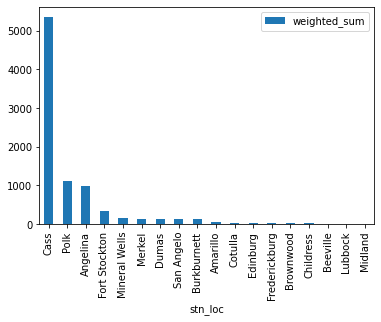

In [226]:
optimal_county_df.groupby('stn_loc').sum().sort_values(by = 'weighted_sum',ascending = False).reset_index().plot(kind = 'bar',x = 'stn_loc',y = 'weighted_sum')

In [232]:
big_df[big_df['StartYear']==2019]['DiscoveryAcres'].sum()

460519.6500000001

In [233]:
big_df[big_df['StartYear']==2022]['DiscoveryAcres'].sum()

1029288.631

In [263]:
abcd = stn_loc.groupby('stn_loc').sum().sort_values(by = 'weighted_sum',ascending = False).reset_index()
abcd['weighted_sum'] = abcd['weighted_sum'].round(2)
fig = px.bar(abcd, x='stn_loc', y='weighted_sum',
        text='weighted_sum')
fig.update_xaxes(title_text = 'Station Location')
fig.update_layout(title={
        'text': 'WWF (Weighted Wildfire Frequency)',
        'x': 0.5,
        'y': 0.9,
        'xanchor': 'center',
        'yanchor': 'top'},
         plot_bgcolor='rgba(0,0,0,0)')
fig.update_layout(yaxis_visible=False)
fig.show()

In [254]:
stn_loc.groupby('stn_loc').sum().sort_values(by = 'weighted_sum',ascending = False).reset_index()

,stn_loc,wf_loc,duration,distance,score,weighted_sum,weighted_mean
0,Cass,8859652,14810063.0,266997288.5,3383.920173,5354.486937,4113.906389
1,Polk,6670461,9330413.7,187903097.2,2052.206259,2811.078877,2464.888139
2,Angelina,6670461,8416780.9,158367560.6,2052.206259,2554.424394,2464.888139
3,Lubbock,1823183,8520076.3,198390937.0,319.209448,1731.840881,1261.307208
4,Brownwood,2408119,6162969.0,127749239.5,361.938050,1041.721519,1555.847583
5,Childress,1823183,4324328.1,92945189.4,319.209448,855.803264,1261.307208
6,Midland,1451371,5057139.1,101900525.7,232.860634,818.574602,1294.677685
7,Burkburnett,2408119,5972578.3,126386422.0,361.938050,764.906374,1555.847583
8,Merkel,2408119,4732869.8,101124271.8,361.938050,750.701081,1555.847583
9,San Angelo,1451371,4653549.0,92249244.2,232.860634,730.602292,1294.677685


<AxesSubplot:xlabel='stn_loc'>

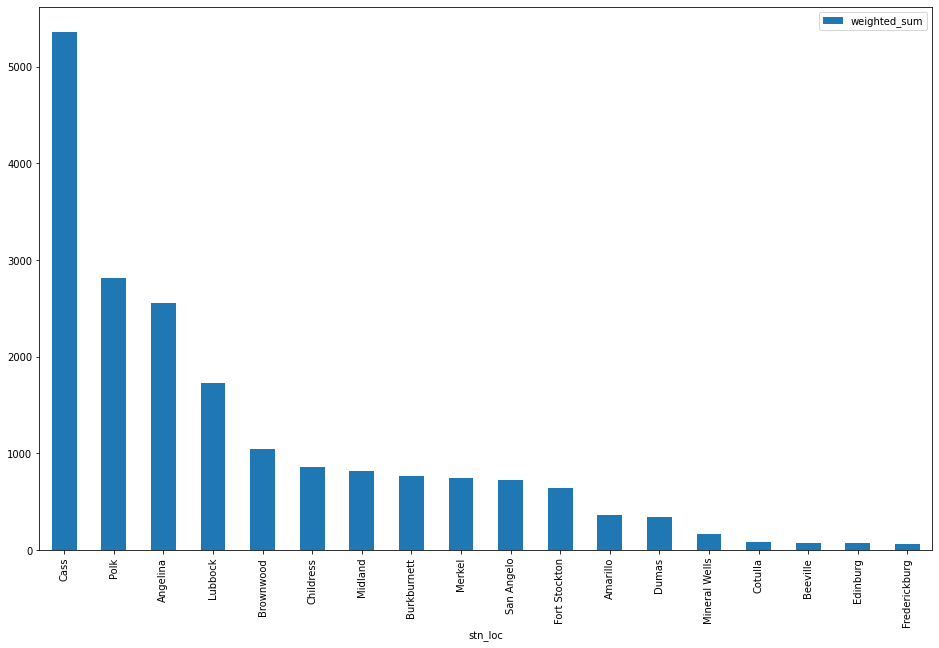

In [251]:
stn_loc.groupby('stn_loc').sum().sort_values(by = 'weighted_sum',ascending = False).reset_index().plot(kind = 'bar',
                                                                                                       x = 'stn_loc',
                                                                                                       y = 'weighted_sum',
                                                                                                       figsize = (16,10))